### Load data, see DatasetLoader.ipynb

In [3]:
import os

TRAIN_PATH = "../../Dataset/withGT"
#TEST_PATH = "../../Dataset/MHA/Test"

if not os.path.exists(TRAIN_PATH):
    print("Please update your data path to an existing folder.")
elif not '.mha' in os.listdir(TRAIN_PATH)[0]:
    print("The folder exists there are no MHA files found.")
else:
    print("Congrats! You selected the correct folder :)")

Congrats! You selected the correct folder :)


../../Dataset/withGT/TRV1P3
../../Dataset/withGT/TRV1P3
../../Dataset/withGT/TRV1P3
../../Dataset/withGT/TRV1P3
../../Dataset/withGT/TRV1P3
../../Dataset/withGT/TRV1P3
../../Dataset/withGT/TRV1P4
../../Dataset/withGT/TRV1P4
../../Dataset/withGT/TRV1P4
../../Dataset/withGT/TRV1P5
../../Dataset/withGT/TRV1P5
../../Dataset/withGT/TRV1P5
../../Dataset/withGT/TRV1P5
../../Dataset/withGT/TRV1P5
../../Dataset/withGT/TRV1P5
../../Dataset/withGT/TRV1P6
../../Dataset/withGT/TRV1P6
../../Dataset/withGT/TRV1P7
../../Dataset/withGT/TRV1P7
../../Dataset/withGT/TRV1P7
../../Dataset/withGT/TRV1P7
../../Dataset/withGT/TRV1P7
../../Dataset/withGT/TRV1P7
../../Dataset/withGT/TRV1P7
../../Dataset/withGT/TRV1P7
../../Dataset/withGT/TRV1P7
../../Dataset/withGT/TRV1P7
../../Dataset/withGT/TRV1P8
../../Dataset/withGT/TRV1P8
../../Dataset/withGT/TRV1P8
../../Dataset/withGT/TRV1P8
../../Dataset/withGT/TRV1P8
../../Dataset/withGT/TRV1P8
../../Dataset/withGT/TRV1P8
../../Dataset/withGT/TRV1P8
../../Dataset/withGT

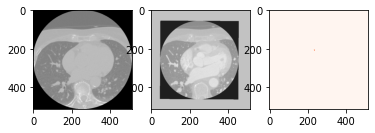

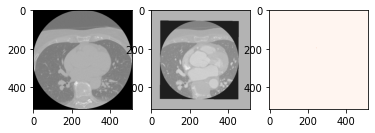

The distrubution of annotations in the trainset
Ratio with GT: 100.0 %
Area of GT in total: 0.021601782904730905 %


In [6]:
# from torch.utils.data import Dataset
from monai.data import Dataset
import monai
import torchsummary
import torch
import itk
from matplotlib import pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter

class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, regImg_ext, transforms=None):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.images = self.load_mha_images(imagePaths,['CTI',regImg_ext,'R'])
		self.loadedImages = self.images['CTI']
		self.loadedMask = self.images['R']
		self.transforms = transforms

	def load_mha_images(self, paths, ext):
		img = dict()
		counter_reference = 0
		for i in paths:
			if len(ext)>1:
				R_image = np.clip(itk.GetArrayFromImage(itk.imread(i+""+ext[2]+".mha")),0,1)
				CTI_image = itk.GetArrayFromImage(itk.imread(i+""+ext[0]+".mha"))
				CTAI_image = itk.GetArrayFromImage(itk.imread(i+""+ext[1]+".mha"))
				if not (len(CTI_image) == len(CTAI_image) == len(R_image)):
					raise ValueError("Lengths (slices) of "+i+" are not the same!")
				for j in range(len(CTI_image)):
					if 1 in R_image[j]:						
						print(i)
						if ext[0] in img:
							img[ext[0]].append(torch.stack((torch.FloatTensor(CTI_image[j]),torch.FloatTensor(CTAI_image[j]))))
							img[ext[2]].append(torch.FloatTensor(R_image[j]))
						else:
							img[ext[0]] = [torch.stack((torch.FloatTensor(CTI_image[j]),torch.FloatTensor(CTAI_image[j])))]
							img[ext[2]] = [torch.FloatTensor(R_image[j])]
		return img

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.images['CTI'])

	def __getitem__(self, idx):
		# grab the image path from the current index
		image = self.loadedImages[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		mask = self.loadedMask[idx]
		# check to see if we are applying any transformations
		if self.transforms is not None:
			# apply the transformations to both image and its mask
			image = self.transforms(image)
			mask = self.transforms(mask)
		# return a tuple of the image and its mask
		return (image, mask)

train_image_CTI_paths = list(filter(lambda x: 'CTI' in x,os.listdir(TRAIN_PATH)))
train_image_paths = []
for i in train_image_CTI_paths:
    train_image_paths.append(TRAIN_PATH+"/"+i[:6])


train_dataset = SegmentationDataset(train_image_paths,'CTAI_0')
print(len(train_dataset))

for i in range(2):
    fig, axes = plt.subplots(1,3)
    axes[0].imshow(train_dataset[i][0][0].numpy(),cmap=plt.cm.gray) # [i][0][0] CT
    axes[1].imshow(train_dataset[i][0][1].numpy(),cmap=plt.cm.gray) # [i][0][1] CTA
    axes[2].imshow(train_dataset[i][1].numpy(),cmap=plt.cm.Reds)	# [i][1] 	GT
    plt.show()

count = 0
sumation = 0
for i in train_dataset:
    if 1 in i[1].numpy():
        sumation += np.sum(i[1].numpy())
        count += 1

print("The distrubution of annotations in the trainset")
print("Ratio with GT:",count/len(train_dataset)*100,"%")
print("Area of GT in total:",sumation/(len(train_dataset)*512*512)*100,"%")

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=2,
    out_channels=1,
    channels = (8, 8, 16, 32, 64),
    strides=(1, 1, 1, 1),
    bias=True,
    kernel_size=3,
).to(DEVICE)

torchsummary.summary(model,(2,512,512))

loss_function =  monai.losses.GeneralizedDiceLoss(sigmoid=True, batch=False)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [4]:
# # traindataset:[INDEX][ SCAN:[CT,CTA]] , GT ]
# # print(model)
# print(len(train_dataset))
# x = torch.stack(train_dataset[:][0])

# fig, axes = plt.subplots(2,2)
# axes[0][0].imshow(x[0][0].numpy(),cmap=plt.cm.gray) # [i][0][0] CT
# axes[0][1].imshow(x[0][1].numpy(),cmap=plt.cm.gray) # [i][0][1] CTA
# axes[1][0].imshow(x[1][0].numpy(),cmap=plt.cm.gray) # [i][0][0] CT
# axes[1][1].imshow(x[1][1].numpy(),cmap=plt.cm.gray) # [i][0][1] CTA
# # axes[2].imshow(train_dataset[i][1].numpy(),cmap=plt.cm.Reds)	# [i][1] 	GT
# plt.show()

# print(x.size())
# print(model(x[:2]))

In [15]:
def train_model(model,train_ds,epochs):
    # start a typical PyTorch training
    epoch_loss_values = list()
    metric_values = list()
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_ds:
            step += 1
            inputs, labels = batch_data[0].to(DEVICE), batch_data[1]
            optimizer.zero_grad()
            
            #Labels smoothing
            labels = torch.FloatTensor(gaussian_filter(labels.numpy(), sigma=5))
            labels[np.where(labels>0)]=1
            labels = labels.to(DEVICE)
            
            inputs = inputs.unsqueeze(1).permute(1,0,2,3)
            labels = labels.unsqueeze(0).unsqueeze(0)

            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_len = len(train_ds)
            print(f"epoch {epoch+1} | {step}/{epoch_len}, train_loss: {loss.item():.6f}",end='\r')
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"> epoch {epoch + 1}/{epochs} average loss: {epoch_loss:.4f}                                        ")

train_model(model,train_dataset,30)

> epoch 1/30 average loss: 0.9539                                        
> epoch 2/30 average loss: 0.9726                                        
> epoch 3/30 average loss: 0.9726                                        
> epoch 4/30 average loss: 0.9726                                        


KeyboardInterrupt: 